# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
os.environ['KERAS_BACKEND']='tensorflow'

import tensorflow as tf
tf.__version__

# ## Use tensorflow with CPU
# import tensorflow as tf
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)
# from keras import backend as K
# K.tensorflow_backend.set_session(session=sess)

'1.2.0'

In [4]:
import numpy as np

from data_utils import get_id_type_list_for_class, GENERATED_DATA, OUTPUT_PATH, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

No test data found at D:\vfomin\MyExamples\python\planet_amazon_rainforest\input\test 
No additional test data found at D:\vfomin\MyExamples\python\planet_amazon_rainforest\input\test 


Using TensorFlow backend.


In [5]:
from models.squeezenet_multiclassification import get_squeezenet, get_squeezenet21

In [6]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import load_pretrained_model, get_label

In [7]:
from xy_providers import image_label_provider
from models.keras_metrics import mae_with_false_negatives, binary_crossentropy_with_false_negatives

In [8]:
cnn = get_squeezenet21((256, 256, 3), 17)
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 127, 127, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 127, 127, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 63, 63, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

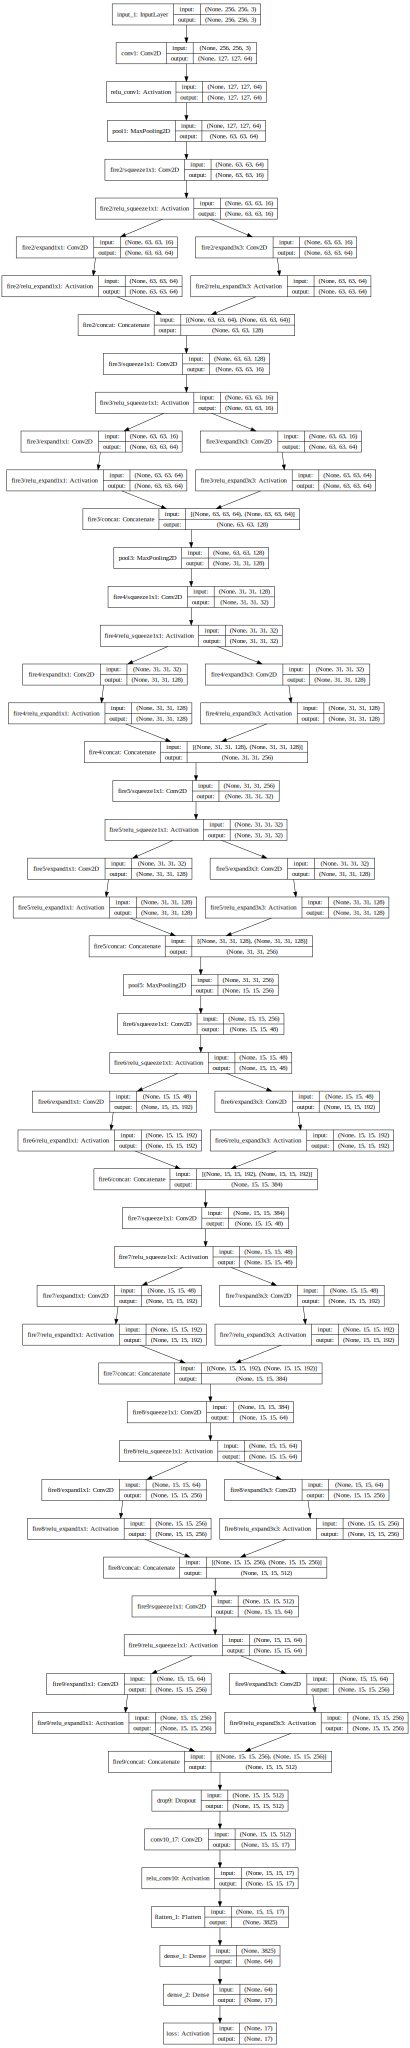

In [8]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

### Setup configuration

In [15]:
seed = 2017
np.random.seed(seed)

In [16]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]
np.random.shuffle(trainval_id_type_list)
print(len(trainval_id_type_list))

40479


In [17]:
40479 * 256**2 * 3 / 1024.0 /1024.0

7589.8125

In [18]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(10000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(10000)

In [19]:
params = {
    'seed': seed,

    'xy_provider': image_label_provider,

    'network': get_squeezenet21,
    'optimizer': 'adadelta',
    'loss': 'binary_crossentropy', # mae_with_false_negatives,
    'nb_epochs': 25,    
    'batch_size': 16,  

    'normalize_data': True,
    'normalization': 'vgg',

    'image_size': (256, 256),

    # Learning rate scheduler
    'lr_kwargs': {
        'lr': 0.01,
        'a': 0.956,
        'init_epoch': 0
    },
    'lr_decay_f': exp_decay,

    # Reduce learning rate on plateau
    'on_plateau': True,
    'on_plateau_kwargs': {
        'monitor': 'val_loss',
        'factor': 0.1,
        'patience': 3,
        'verbose': 1
    },

    'cache': cache,

#     'class_index': 0,
#     'pretrained_model': 'load_best',
#     'pretrained_model': os.path.join(GENERATED_DATA, "weights", ""),

    'output_path': OUTPUT_PATH,
}


params['save_prefix_template'] = '{cnn_name}_all_classes_fold={fold_index}_seed=%i' % params['seed']
params['input_shape'] = params['image_size'] + (3,)
params['n_classes'] = len(unique_tags)

## Train on all classes

Start CV

In [21]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]
hists = []

kf = KFold(n_splits=n_folds)
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
            
    val_fold_index += 1
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    
    weights = None if 'pretrained_model' in params else 'imagenet'
    cnn = params['network'](lr=params['lr_kwargs']['lr'], weights=weights, **params)
    params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))
    
    if 'pretrained_model' in params:
        load_pretrained_model(cnn, **params)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  1 / 5
2017-07-08 12:22:30.152321 32383 8096

 2017-07-08 12:22:32.296272 - Loaded SqueezeNet21 model ...

 2017-07-08 12:22:32.296381 - Start training ...

-- Training parameters: 16, 25, 32384, 8112

-- Fit model
- New Keras API found -

Epoch validation: f2 = 0.456578, mae=0.556549 

Epoch 1/25
2024/2024 [==============================] - 1828s - loss: 0.6951 - precision: 0.4102 - recall: 0.6133 - val_loss: 0.2854 - val_precision: 0.7990 - val_recall: 0.5901

Epoch validation: f2 = 0.713466, mae=0.116666 

Epoch 2/25
2024/2024 [==============================] - 1571s - loss: 0.3521 - precision: 0.5776 - recall: 0.6072 - val_loss: 0.2472 - val_precision: 0.8427 - val_recall: 0.5846

Epoch validation: f2 = 0.717449, mae=0.101074 

Epoch 3/25
2024/2024 [==============================] - 1732s - loss: 0.3190 - precision: 0.6269 - recall: 0.6321 - val_loss: 0.2360 - val_precision: 0.8739 - val_recall: 0.5717

Epoch validation: f2 = 0.727869, mae=0.092958 



In [14]:
# output_path = params['output_path'] if 'output_path' in params else OUTPUT_PATH
# weights_path = os.path.join(output_path, "weights")
# weights_filename = os.path.join(weights_path, params['save_prefix'] + "_31_val_loss=6.9420.h5")

# cnn.save_weights(weights_filename)

### Validation all classes

In [12]:
n_runs = 2
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = [0,]

In [15]:
params['pretrained_model'] = 'load_best'

In [16]:
_trainval_id_type_list = np.array(trainval_id_type_list)

while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in kf.split(_trainval_id_type_list):        
        train_id_type_list, val_id_type_list = _trainval_id_type_list[train_index], _trainval_id_type_list[test_index]
        
        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue

        val_fold_index += 1        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        load_pretrained_model(cnn, **params)

        params['seed'] += run_counter - 1 

        f2, mae = validate(cnn, val_id_type_list, verbose=0, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = f2
        
        np.random.shuffle(_trainval_id_type_list)
    
print(cv_mean_scores)



 ---- New run :  2 / 2


 ---- Validation fold index:  1 / 5
32383 8096

 2017-07-07 21:28:45.790966 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/common/../resources/SqueezeNet2_all_classes_fold=0_seed=2017_06_val_loss=0.1624_val_precision=0.8075_val_recall=0.5909.h5 0.1624
[[ 0.          0.          0.          0.          0.        ]
 [ 0.66542271  0.          0.          0.          0.        ]]


In [16]:
np.mean(cv_mean_scores)

0.12974190795430113

### Visual validation

In [20]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile
from metrics import score
from sklearn.metrics import mean_absolute_error, fbeta_score

import matplotlib.pylab as plt
%matplotlib inline

In [21]:
n_folds = 5
val_fold_index = 1

params['pretrained_model'] = 'load_best'

cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'], weights=None)
params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)        
load_pretrained_model(cnn, **params)

Load best loss weights:  D:\vfomin\MyExamples\python\planet_amazon_rainforest\common\..\resources\SqueezeNet21_all_classes_fold=0_seed=2017_24_val_loss=0.2772_val_precision=0.8616_val_recall=0.6403.h5 0.2772


In [22]:
kf = KFold(n_splits=n_folds)
_trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(_trainval_id_type_list):        
    train_id_type_list, val_id_type_list = _trainval_id_type_list[train_index], _trainval_id_type_list[test_index]
    break

In [23]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=val_id_type_list, 
                                 imgaug_seq=imgaug_seq, 
                                 test_mode=True, verbose=0, **params)
channels_first = False

info names:  ('17819', 'Train_jpg')

-- ('17819', 'Train_jpg')
y_true:  [0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
y_pred:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
mae:  0.330206
f2:  0.277777777778

-- ('20708', 'Train_jpg')
y_true:  [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
y_pred:  [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
mae:  0.0834594
f2:  1.0

-- ('16649', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
y_pred:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
mae:  0.0320204
f2:  1.0

-- ('25548', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
y_pred:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
mae:  0.0677391
f2:  1.0

-- ('30805', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
y_pred:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
mae:  0.0416871
f2:  1.0

-- ('13819', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
y_pred:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
mae:  0.0229899
f2:  1.0

-- ('26229', 'Train_jpg')
y_true:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
y_pred:  [1 0 0 0 0 1 0 0 0 0 

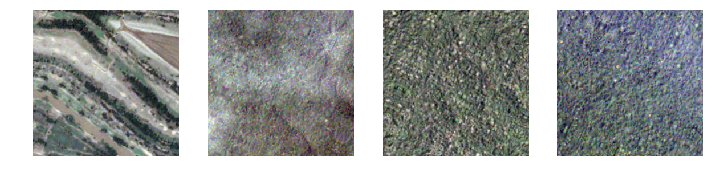

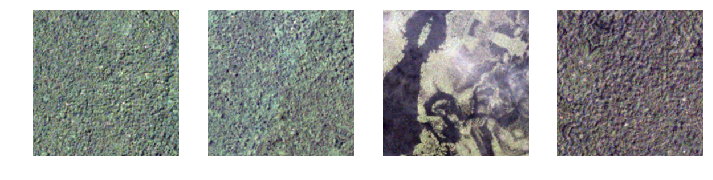

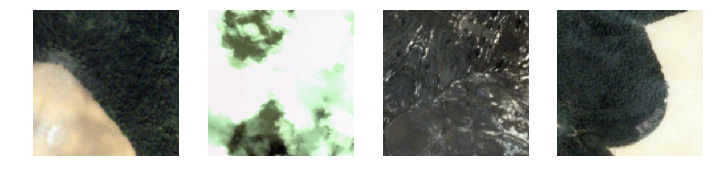

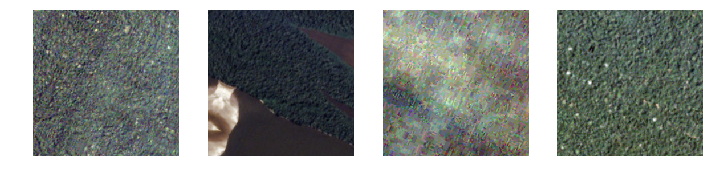

In [24]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict_on_batch(x)
    n = 4
    
    print('info names: ', info[:][0])
    
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', (y_pred[counter, :] > 0.5).astype(np.uint8))
        print('mae: ', mean_absolute_error(y_true[counter, :], y_pred[counter, :]))  
        print('f2: ', fbeta_score(y_true[counter, :], y_pred[counter, :] > 0.5, beta=2.0))          
        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    

## Predict tags on test data

In [11]:
from data_utils import test_jpg_ids, test_jpg_additional_ids
from test_utils import classification_predict as predict

In [55]:
test_id_type_list = []
test_id_type_list1 = []
for image_id in test_jpg_ids:
    test_id_type_list1.append((image_id, "Test_jpg"))

test_id_type_list2 = []
for image_id in test_jpg_additional_ids:
    test_id_type_list2.append((image_id, "ATest_jpg"))
    
test_id_type_list.extend(test_id_type_list1)
test_id_type_list.extend(test_id_type_list2)
print(len(test_id_type_list))

61191


In [49]:
len(set(test_id_type_list1)), len(set(test_id_type_list2)),

(40669, 20522)

In [114]:
n_folds = 1
predictions = []
run_counter = 0
n_runs = 1
params['pretrained_model'] = 'load_best'
params['batch_size'] = 7

In [115]:
while run_counter < n_runs:
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)

    # SqueezeNet on 5 folds
    for val_fold_index in range(n_folds):
                
        val_fold_index += 1
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        
        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        params['save_prefix'] = params['save_prefix_template'].format(cnn_name=cnn.name, fold_index=val_fold_index-1)
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        load_pretrained_model(cnn, **params)
        
        params['seed'] += run_counter - 1 
        df = predict(cnn, cp_test_id_type_list[61184:], **params)
        predictions.append(df)
 



 ---- New run :  1 / 1


 ---- Validation fold index:  1 / 1

 2017-07-08 09:15:14.371500 - Loaded SqueezeNet2 model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/common/../resources/SqueezeNet2_all_classes_fold=0_seed=2017_06_val_loss=0.1624_val_precision=0.8075_val_recall=0.5909.h5 0.1624
Image normalization:  vgg
Image id/type: 1211 ATest_jpg | counter= 0
-- Load from RAM
Image id/type: 11695 ATest_jpg | counter= 1
-- Load from RAM
Image id/type: 15276 ATest_jpg | counter= 2
-- Load from RAM
Image id/type: 3009 ATest_jpg | counter= 3
-- Load from RAM
Image id/type: 6343 ATest_jpg | counter= 4
-- Load from RAM
Image id/type: 689 ATest_jpg | counter= 5
-- Load from RAM
Image id/type: 7161 Test_jpg | counter= 6
-- Load from RAM
-- 0 / 7


In [32]:
import pandas as pd

def compute_mean(predictions):
    df = predictions[0]
    for p in predictions[1:]:
        df = pd.concat([df, p], axis=0)
    df = df.apply(pd.to_numeric, errors='ignore')
    gb = df.groupby('image_name')
    df2 = gb.agg(np.mean).reset_index()
    return df2

In [39]:
df = compute_mean(predictions)

# info = 'mean_cv=6_squeezenet'
# now = datetime.now()
# sub_file = 'submission_' + info + '.csv'
# sub_file = os.path.join('results', sub_file)
# df.to_csv(sub_file, index=False)

In [107]:
df_copy = predictions[0].copy()

In [116]:
predictions[0].head(10)

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,file_1211.jpg,2.151546e-05,1.113320e-28,3.231987e-27,2.015345e-22,2.301800e-29,1.0,3.163078e-24,5.840415e-21,2.772029e-25,1.094865e-35,2.397000e-15,4.335730e-12,1.0,4.143251e-25,1.434911e-38,4.450723e-05,2.845508e-38
1,file_11695.jpg,6.445390e-05,9.896077e-20,2.376191e-20,4.798834e-18,1.087365e-19,1.0,2.366972e-20,3.564780e-16,2.262317e-18,3.627134e-26,3.144834e-08,1.169919e-05,1.0,3.350850e-21,4.533524e-26,1.700110e-06,2.252979e-27
2,file_15276.jpg,2.029497e-09,4.028379e-30,1.258803e-27,6.536340e-28,5.706498e-34,1.0,9.110444e-33,2.724927e-22,7.019449e-30,5.127296e-38,7.057952e-15,2.045735e-12,1.0,1.525794e-32,3.899064e-38,1.074082e-02,6.908861e-36
3,file_3009.jpg,2.313850e-07,1.552925e-22,5.569044e-24,7.186522e-20,1.343329e-15,1.0,5.006628e-17,1.987333e-17,4.896625e-16,2.611100e-27,2.470989e-09,3.550527e-04,1.0,1.285485e-17,1.471359e-26,3.194779e-05,2.885577e-26
4,file_6343.jpg,5.966594e-12,4.814365e-33,4.636060e-34,4.744340e-32,2.623958e-37,1.0,1.200608e-36,6.104894e-28,4.776368e-34,0.000000e+00,1.175414e-16,2.685906e-11,1.0,1.445798e-35,0.000000e+00,2.420373e-04,0.000000e+00
5,file_689.jpg,2.243616e-04,2.286432e-29,8.452239e-27,2.453667e-21,3.922390e-26,1.0,1.000618e-30,8.813396e-16,6.036509e-28,2.782990e-36,4.782571e-14,7.791865e-10,1.0,1.862010e-26,0.000000e+00,7.783083e-11,0.000000e+00
6,test_7161.jpg,9.862463e-01,3.956240e-29,2.266145e-24,4.042353e-24,3.862132e-30,1.0,1.111537e-22,8.093678e-23,1.299090e-25,6.173257e-34,2.397583e-13,6.773111e-07,1.0,6.173856e-23,0.000000e+00,5.613817e-12,3.110934e-36


In [52]:
# predictions[0].head(10)

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_1.jpg,6.772327e-13,9.580929e-35,4.134071e-36,2.759546e-34,0.000000e+00,1.0,0.000000e+00,3.104341e-29,4.614072e-36,0.000000e+00,1.917775e-21,1.490587e-15,1.0,0.000000e+00,0.000000e+00,1.044505e-03,0.000000e+00
1,test_100.jpg,7.662133e-09,4.367091e-32,1.288420e-32,2.467512e-29,0.000000e+00,1.0,2.147286e-32,1.826154e-28,6.325564e-33,0.000000e+00,4.648061e-21,9.701938e-11,1.0,5.478038e-33,0.000000e+00,3.751816e-09,0.000000e+00
2,file_10002.jpg,4.031350e-03,1.608177e-15,7.242022e-15,1.508867e-12,5.550554e-15,1.0,9.663430e-15,9.094813e-12,1.763371e-13,3.436944e-19,4.632033e-07,5.561814e-05,1.0,5.984665e-14,3.684968e-19,2.553005e-04,1.716136e-19
3,test_1000.jpg,5.365706e-06,5.491102e-22,1.807185e-22,1.799127e-18,6.539262e-27,1.0,3.798515e-22,4.188151e-21,6.636277e-23,2.701022e-28,3.598610e-12,3.132831e-07,1.0,2.329216e-22,2.715504e-30,1.121161e-07,1.269463e-30
4,file_10003.jpg,8.563299e-01,5.050747e-25,2.395254e-23,4.848226e-23,1.240237e-21,1.0,6.760097e-23,7.949230e-21,4.314708e-20,1.749407e-29,7.500155e-10,3.325665e-07,1.0,2.806542e-20,1.497700e-30,3.173337e-10,7.273121e-35
5,test_0.jpg,4.775232e-05,1.682847e-26,5.877881e-26,4.999741e-23,8.220003e-31,1.0,7.723250e-30,2.054528e-24,3.713533e-25,6.780329e-35,4.992329e-15,1.534666e-11,1.0,7.158968e-28,6.354885e-38,2.614485e-05,1.283999e-33
6,test_10.jpg,3.493214e-06,4.904650e-29,2.561067e-26,1.552443e-24,3.089854e-31,1.0,1.459574e-28,1.571561e-20,5.288180e-22,1.063955e-36,1.508937e-07,6.682799e-06,1.0,3.637980e-28,1.049172e-36,1.289439e-09,0.000000e+00
7,file_10000.jpg,7.587548e-11,9.958944e-27,1.468066e-29,1.746884e-25,2.434916e-29,1.0,1.550729e-29,9.395536e-22,3.884757e-28,2.078479e-37,2.345300e-15,1.743952e-09,1.0,1.543587e-29,1.133980e-35,5.391848e-04,9.946251e-37
8,file_10001.jpg,5.733041e-06,6.069436e-28,2.096811e-22,1.609467e-21,2.727900e-23,1.0,1.118571e-25,7.316504e-20,5.172601e-22,2.646097e-33,6.123609e-10,8.115984e-08,1.0,8.862080e-23,2.756612e-33,2.976626e-06,2.133953e-31
9,file_10004.jpg,2.070669e-10,8.462388e-38,4.038451e-33,1.019686e-35,0.000000e+00,1.0,0.000000e+00,5.552097e-31,6.007832e-38,0.000000e+00,6.247752e-23,9.999662e-15,1.0,0.000000e+00,0.000000e+00,7.364623e-06,0.000000e+00


In [119]:
df = predictions[0]

df_ = pd.concat([df_copy, df])

In [127]:
len(df_)

61191

In [166]:
unique_tags

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [169]:
def create_submission(df, info):
    _df = df.copy()
    thresholds = {
        'agriculture': 0.5,
        'artisinal_mine': 0.5,
        'bare_ground': 0.5,
        'blooming': 0.5,
        'blow_down': 0.5,
        'clear': 0.5,
        'cloudy': 0.5,
        'conventional_mine': 0.5,
        'cultivation': 0.5,
        'habitation': 0.5,
        'haze': 0.5,
        'partly_cloudy': 0.5,
        'primary': 0.5,
        'road': 0.5,
        'selective_logging': 0.5,
        'slash_burn': 0.5,
        'water': 0.5
    }
    for tag in unique_tags:
        _df.loc[:, tag] = _df[tag].apply(lambda x : 1 if x > thresholds[tag] else 0)
    _df['tags'] = _df[unique_tags].apply(lambda x: " ".join(np.array(unique_tags)[np.where(x.values)[0]]), axis=1)        
    _df['image_id'] = _df['image_name'].apply(lambda x: int(x[5:]) + (40669 if 'file_' in x else 0))
    _df = _df.sort_values(by='image_id')[['image_name', 'tags']]

#     now = datetime.now()
#     sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
#     sub_file = os.path.join('..', 'results', sub_file)
#     _df.to_csv(sub_file, index=False)
    return _df

In [128]:
df2 = df_.copy()

In [129]:
df2['tags'] = ''

In [130]:
for tag in unique_tags:
    df2.loc[:, tag] = df2[tag].apply(lambda x : 1 if x > 0.5 else 0) 

In [131]:
df2.loc[:, 'tags'] = df2[unique_tags].apply(lambda x: " ".join(np.array(unique_tags)[np.where(x.values)[0]]), axis=1)

In [160]:
df2[['image_name', 'tags']].head()

,image_name,tags
0,test_40308,clear primary
1,test_36168,clear primary
2,test_6070,agriculture clear primary
3,test_5483,clear primary
4,test_5532,clear primary


In [144]:
len(test_id_type_list1)

40669

In [161]:
df2['image_id'] = df2['image_name'].apply(lambda x: int(x[5:]) + (40669 if 'file_' in x else 0))

In [162]:
df2['image_id'].tail()

2    55945
3    43678
4    47012
5    41358
6     7161
Name: image_id, dtype: int64

In [163]:
df3 = df2.sort_values(by='image_id')[['image_name', 'tags']]

In [164]:
df3.head()

,image_name,tags
6786,test_0,clear primary
31273,test_1,clear primary
44212,test_2,clear primary
7703,test_3,clear primary
9256,test_4,clear primary


In [165]:
info = params['save_prefix']

now = datetime.now()
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
sub_file = os.path.join('..', 'results', sub_file)
df3.to_csv(sub_file, index=False)

In [158]:
len(df3['image_name']), len(df3['image_name'].unique()) 

(61191, 61191)

In [173]:
df_res = create_submission(df_, 'info')

In [175]:
df_res.tail()

,image_name,tags
18365,file_20517,clear primary
38307,file_20518,clear primary
37974,file_20519,agriculture clear primary
26740,file_20520,clear primary
52458,file_20521,clear primary
